<a href="https://colab.research.google.com/github/Kittsxy/bank-stock-prediction-lstm/blob/main/BMRI%20Stock%20Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from datetime import datetime
import seaborn as sns
import math
import pickle
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from keras.models import Sequential
from keras.layers import Bidirectional, Flatten, Dense
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import L1L2
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.layers import LSTM
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.regularizers import l1_l2
from tensorflow.keras.layers import Dense, Bidirectional, GRU, LSTM
from tensorflow.keras.regularizers import l1_l2

In [ ]:
from statistics import stdev

def Average(data):
    return sum(data) / len(data)

# Z-Scores
def normalize_series(data, mean, std):
    data = data - mean
    data = data / std
    return data

def inverse_normalize_series(data, mean, std):
    data = data * std
    data = data + mean
    return data

In [ ]:
def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

In [ ]:
# Datetime
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

In [ ]:
# Multisteps Forecast
def multi_step_forecasts(n_lookback, n_forecast, model, data, data_scaled):

    input_forecast = data_scaled[-n_lookback:]
    x_forecast = input_forecast.reshape(1, n_lookback, 1)

    y_future = [] # predicted target values

    for i in range(n_forecast):
        # generate the next forecast
        output = model.predict(x_forecast)

        # transform the forecasts back to the original scale
        normal_output = inverse_normalize_series(output, Average(data), stdev(data.flatten()))

        # save the forecast
        y_future.append(list(normal_output[0]))

        # feed the last forecast back to the model as an input
        x_forecast = np.append(x_forecast, output.flatten()[0])

        # reshape to fit the input model
        x_forecast = x_forecast[-n_lookback:].reshape(1, n_lookback, 1)


    return y_future

In [ ]:
df = pd.read_csv("/content/BMRI.JK Close.csv",sep=";")

In [ ]:
df['Date'] = df['Date'].apply(pd.to_datetime)
df.info()

<ipython-input-9-fe3be03317d7>:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = df['Date'].apply(pd.to_datetime)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2726 entries, 0 to 2725
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2726 non-null   datetime64[ns]
 1   Close   2726 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 42.7 KB


In [ ]:
df.head()

,Date,Close
0,2013-02-01,2062
1,2013-03-01,2050
2,2013-04-01,2062
3,2013-07-01,2050
4,2013-08-01,2087


In [ ]:
dataSize = len(df)
print(dataSize)

2726


In [ ]:
# Membuat date sequence

dataset_date = [dt.strftime('%Y-%m-%d') for dt in
       datetime_range(datetime(2013,2,1), datetime(2023,12,29),
       relativedelta(days=1))]

print(len(df))
print(np.shape(dataset_date))

2726
(3983,)


In [ ]:
# Mengonversi Skalar/Array/Series Menjadi Objek DateTime
# Ensure that the length of dataset_date matches the length of df
#dataset_date = dataset_date[:len(df)]  # Trim dataset_date to match df length

#df['Date'] = dataset_date
#df['Date'] = df['Date'].apply(pd.to_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2726 entries, 0 to 2725
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2726 non-null   datetime64[ns]
 1   Close   2726 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 42.7 KB


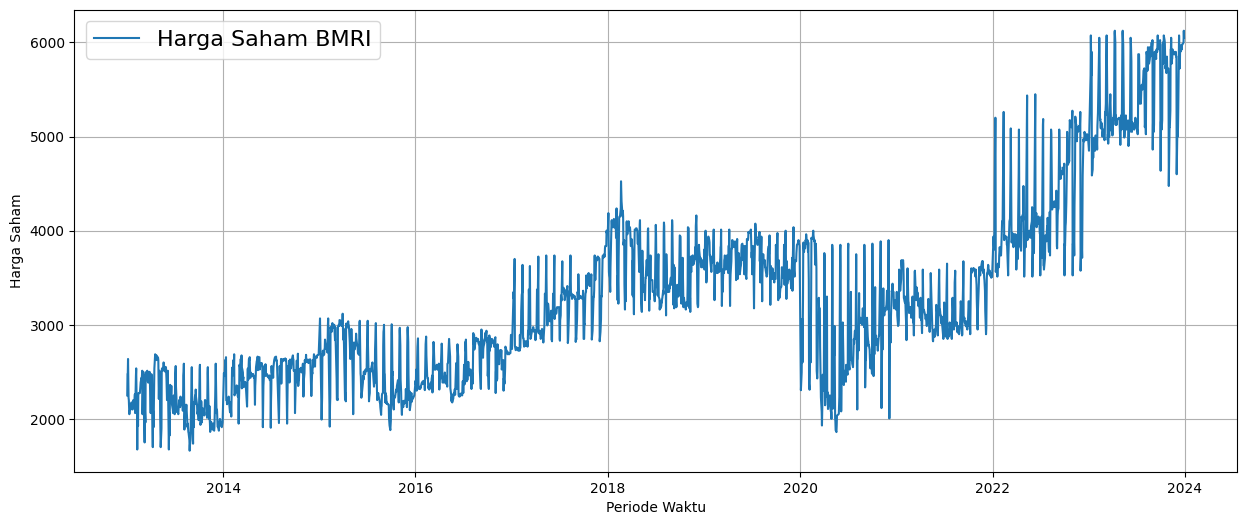

In [ ]:
# Plot Data
plt.subplots(figsize=(15, 6))
sns.lineplot(x="Date", y="Close", data=df, label='Harga Saham BMRI')
plt.xlabel('Periode Waktu')
plt.ylabel('Harga Saham')
plt.legend(loc='upper left', prop={'size': 16})
plt.grid()
plt.show()

In [ ]:
# Mengetahui Summary dari Dataset
df.describe()

,Date,Close
count,2726,2726.000000
mean,2018-06-30 05:27:30.770359296,3289.028247
min,2013-01-02 00:00:00,1662.000000
25%,2015-10-13 12:00:00,2537.000000
50%,2018-06-30 12:00:00,3137.000000
75%,2021-03-17 18:00:00,3762.000000
max,2023-12-29 00:00:00,6125.000000
std,NaN,960.917836


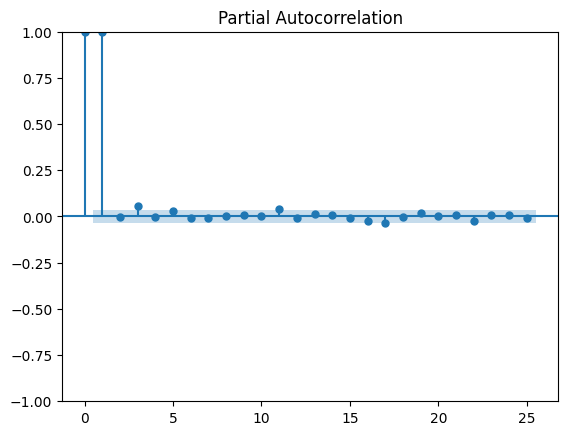

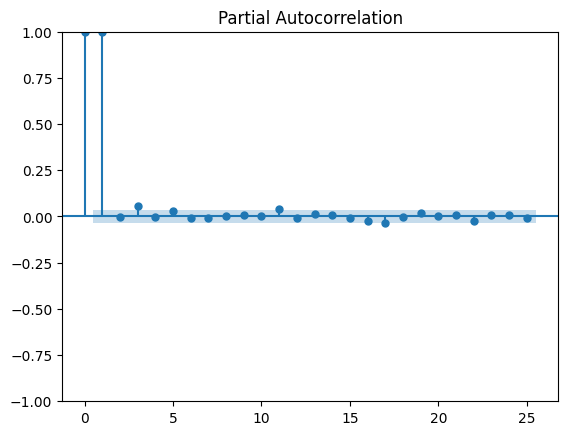

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['Close'],lags=25)

In [ ]:
# Menentukan Timestep yang Akan Dipakai
n_lookback = 90

In [ ]:
# Menentukan Proporsi Pembagian Data Training dan Data Testing
SPLIT_TIME_TRAIN_VAL = int(math.floor(0.75*((len(df))/n_lookback)) * n_lookback)
SPLIT_TIME_TRAIN_VAL

1980

In [ ]:
data_train = df[:SPLIT_TIME_TRAIN_VAL]['Close']
data_train = pd.DataFrame(data_train)
data_train.index = df[:SPLIT_TIME_TRAIN_VAL]['Date']

data_val = df[SPLIT_TIME_TRAIN_VAL:]['Close']
data_val = pd.DataFrame(data_val)
data_val.index = df[SPLIT_TIME_TRAIN_VAL:]['Date']

print(len(data_train)/len(df))
print(len(data_val)/len(df))

0.7263389581804842
0.2736610418195158


In [ ]:
# Melihat Data Training/Pelatihan
data_train.head()

,Close
Date,
2013-02-01,2062
2013-03-01,2050
2013-04-01,2062
2013-07-01,2050
2013-08-01,2087


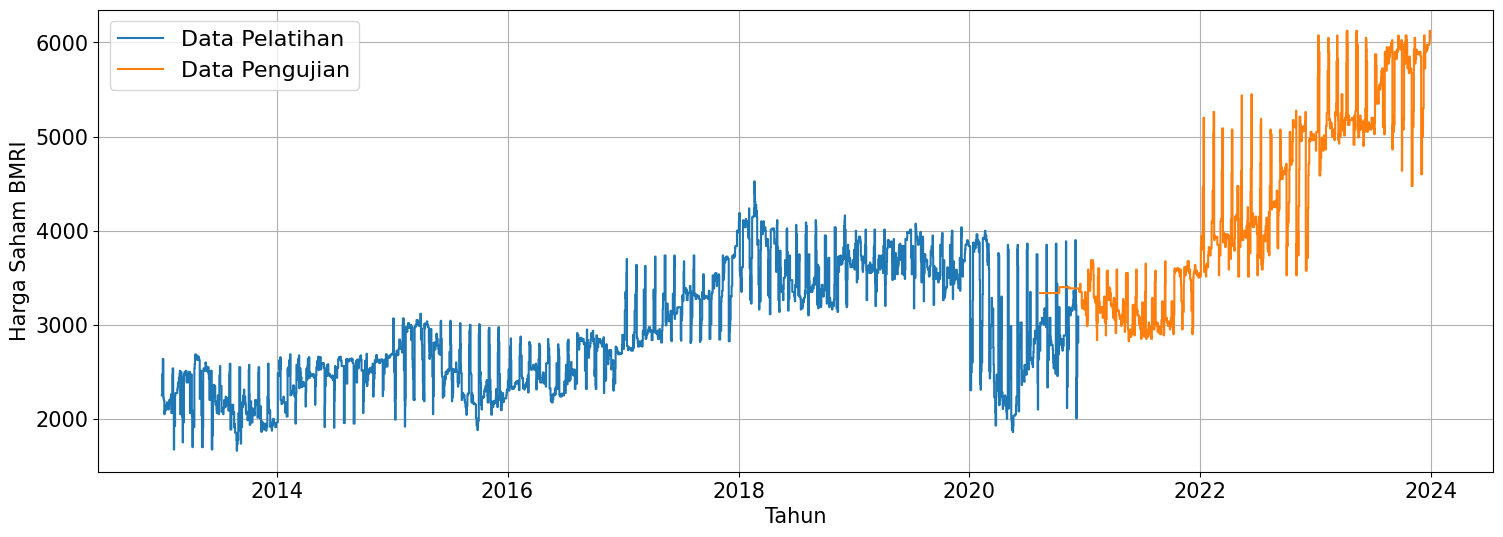

In [ ]:
# Plot Pembagian Data Training dan Data Testing
plt.subplots(figsize = (18,6))
ax=sns.lineplot(x="Date", y="Close",
             data=data_train, drawstyle='steps-post', label='Data Pelatihan')
ax=sns.lineplot(x="Date", y="Close",
             data=data_val, drawstyle='steps-post', label='Data Pengujian')
plt.legend(loc='upper left', prop={'size': 16})
plt.xlabel('Tahun', fontsize=15); plt.ylabel('Harga Saham BMRI', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.grid()

In [ ]:
# Mengubah Dimensi Dataset
bmri = df["Close"].values.reshape(-1, 1)

bmri_train = data_train.values.reshape(-1, 1)

bmri_val = data_val.values.reshape(-1, 1)

print(bmri_train.shape);print(bmri_val.shape)

(1980, 1)
(746, 1)


In [ ]:
# Melihat Data Pelatihan yang Sudah Diubah Dimensinya
bmri_train[:5]

array([[2062],
       [2050],
       [2062],
       [2050],
       [2087]])

In [ ]:
# Membuat Variabel Baru x_train dan y_train
x_train = []
y_train = []

for i in range(n_lookback, len(bmri_train)):
    x_train.append(bmri_train[i - n_lookback: i])
    y_train.append(bmri_train[i])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(1890, 90, 1)
(1890, 1)


In [ ]:
# Membuat Variabel Baru x_val dan y_val
x_val = []
y_val = []

for i in range(n_lookback, len(bmri_val)):
    x_val.append(bmri_val[i - n_lookback: i])
    y_val.append(bmri_val[i])

x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val.shape)
print(y_val.shape)

(656, 90, 1)
(656, 1)


In [ ]:
# Scalling Dataset
bmri_scaled = normalize_series(bmri, Average(bmri), stdev(bmri.flatten()))

bmri_train_scaled = normalize_series(bmri_train, Average(bmri_train), stdev(bmri_train.flatten()))

bmri_val_scaled = normalize_series(bmri_val, Average(bmri_val), stdev(bmri_val.flatten()))

In [ ]:
# Data Sebelum Dilakukan Scalling
bmri[0:5]

array([[2062],
       [2050],
       [2062],
       [2050],
       [2087]])

In [ ]:
# Data Sesudah Dilakukan Scalling
bmri_scaled[0:5]

array([[-1.27693363],
       [-1.2894217 ],
       [-1.27693363],
       [-1.2894217 ],
       [-1.25091684]])

In [ ]:
# Membuat Feature dan label Untuk Data Pelatihan Dari Data yang Sudah Discalling
x_train_scaled = []
y_train_scaled = []

for i in range(n_lookback, len(bmri_train_scaled)):
    x_train_scaled.append(bmri_train_scaled[i - n_lookback: i])
    y_train_scaled.append(bmri_train_scaled[i])

x_train_scaled = np.array(x_train_scaled)
y_train_scaled = np.array(y_train_scaled)
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(1890, 90, 1)
(1890, 1)


In [ ]:
# Melihat Dimensi Dari Data Pertama
print(x_train[0].shape)

(90, 1)


In [ ]:
# Membuat Feature dan label Untuk Data Pengujian Dari Data yang Sudah Di scalling
x_val_scaled = []
y_val_scaled = []

for i in range(n_lookback, len(bmri_val_scaled)):
    x_val_scaled.append(bmri_val_scaled[i - n_lookback: i])
    y_val_scaled.append(bmri_val_scaled[i])

x_val_scaled = np.array(x_val_scaled)
y_val_scaled = np.array(y_val_scaled)
print(x_val_scaled.shape)
print(y_val_scaled.shape)

(656, 90, 1)
(656, 1)


In [ ]:
# Membuat Arsitektur Model yang Akan Digunakan

# Model LSTM
model = Sequential()
model.add(LSTM(64, return_sequences=False, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.5), input_shape=(n_lookback,1)))
model.add(Dense(1))
model.compile(loss='huber', optimizer=Adam(learning_rate=0.00005))

In [ ]:
# Menentukan File Tujuan Untuk Menyimpan Bobot Model
filepath = "best_model.h5"

# Membuat ModelCheckpoint Callback Untuk Menyimpan Bobot Model
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                save_best_only=True,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='min')

# Membuat Konfigurasi EarlyStopping Callback yang Berfungsi Untuk Memberhentikan Proses Training Ketika Nilai Loss Berhenti Membaik
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Fit the model to the data
history = model.fit(x_train_scaled, y_train_scaled, epochs=2000, validation_data=(x_val_scaled, y_val_scaled) ,batch_size=64,verbose=1, callbacks=[checkpoint, early_stopping])

Epoch 1/2000
30/30 [==============================] - 3s 56ms/step - loss: 1.7853 - val_loss: 1.7562
Epoch 2/2000
30/30 [==============================] - 1s 44ms/step - loss: 1.7269 - val_loss: 1.6978
Epoch 3/2000
30/30 [==============================] - 1s 45ms/step - loss: 1.6701 - val_loss: 1.6418
Epoch 4/2000
30/30 [==============================] - 1s 45ms/step - loss: 1.6151 - val_loss: 1.5867
Epoch 5/2000
30/30 [==============================] - 1s 45ms/step - loss: 1.5602 - val_loss: 1.5307
Epoch 6/2000
30/30 [==============================] - 2s 65ms/step - loss: 1.5037 - val_loss: 1.4720
Epoch 7/2000
30/30 [==============================] - 2s 66ms/step - loss: 1.4427 - val_loss: 1.4067
Epoch 8/2000
30/30 [==============================] - 1s 46ms/step - loss: 1.3740 - val_loss: 1.3309
Epoch 9/2000
30/30 [==============================] - 1s 45ms/step - loss: 1.2860 - val_loss: 1.2290
Epoch 10/2000
30/30 [==============================] - 1s 45ms/step - loss: 1.2111 - val_lo

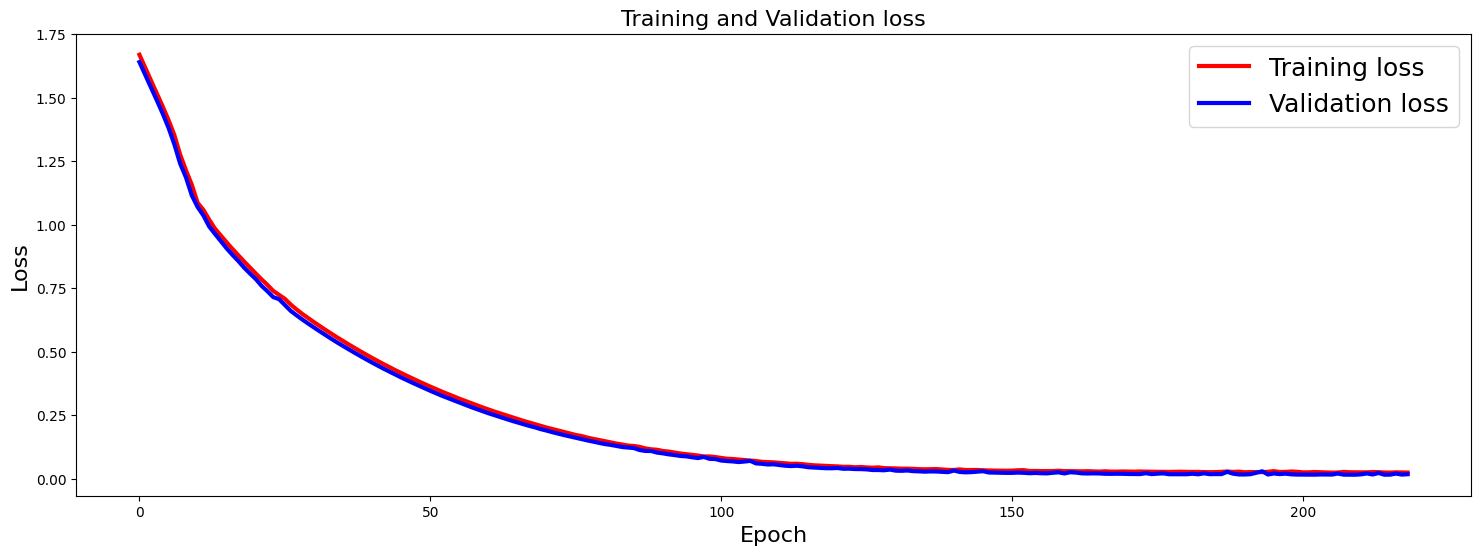

In [ ]:
# Plot Loss Dari Model Peramalan
plt.figure(figsize=[18,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss','Validation loss'],fontsize=18)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Training and Validation loss',fontsize=16)
plt.show()

In [ ]:
forecast_train_data = model_forecast(model,bmri_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(bmri_train_scaled.shape[0]-n_lookback)

1891/1891 [==============================] - 14s 8ms/step
(1891, 1)
(1890,)
1890


In [ ]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(bmri_train), stdev(bmri_train.flatten()))
forecast_train_data[:5]

array([2559.601131  , 2554.20296816, 2549.96200136, 2545.25661806,
       2539.50347475])

In [ ]:
actual = np.squeeze(bmri_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1890,)
[2537 2537 2512 2512 2600]


In [ ]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

,Date,Actual,Forecast
0,2013-05-14,2537,2559.601131
1,2013-05-15,2537,2554.202968
2,2013-05-16,2512,2549.962001
3,2013-05-17,2512,2545.256618
4,2013-05-20,2600,2539.503475
...,...,...,...
1885,2020-01-12,3262,3270.974514
1886,2020-02-12,3325,3279.988246
1887,2020-03-12,3287,3290.345790
1888,2020-04-12,3300,3301.141353


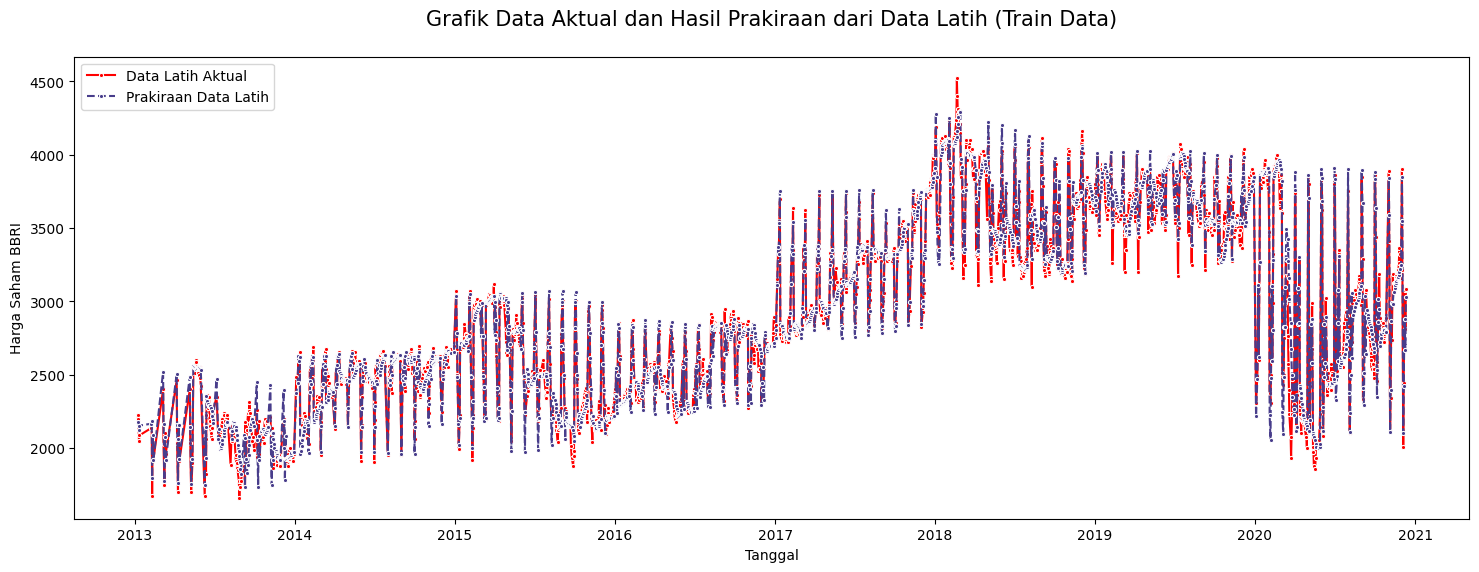

In [ ]:
plt.subplots(figsize=(18, 6))
ax = sns.lineplot(x="Date", y="Actual", data=df_train,
                    label="Data Latih Aktual", marker='.', color = 'red')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train,
                    label="Prakiraan Data Latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Harga Saham BMRI')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [ ]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train Accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,6))

Forecast Train Accuracy
RMSE:  105.3447
MAE:  72.9088
MAPE:  0.025778


In [ ]:
forecast_val_data = model_forecast(model, bmri_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(bmri_val_scaled.shape[0]-n_lookback)

657/657 [==============================] - 5s 8ms/step
(657, 1)
(656,)
656


In [ ]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(bmri_val), stdev(bmri_val.flatten()))
forecast_val_data[:5]

array([3114.36517874, 3101.15289847, 3085.57684866, 3068.12579886,
       3057.29974905])

In [ ]:
actual = np.squeeze(bmri_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(656,)
[3075 2987 3025 3100 3112]


In [ ]:
len(data_val[-forecast_val_data.shape[0]:])

656

In [ ]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

,Date,Actual,Forecast
0,2021-04-23,3075,3114.365179
1,2021-04-26,2987,3101.152898
2,2021-04-27,3025,3085.576849
3,2021-04-28,3100,3068.125799
4,2021-04-29,3112,3057.299749
...,...,...,...
651,2023-12-21,5975,5865.385320
652,2023-12-22,5975,5885.509588
653,2023-12-27,6000,5905.469915
654,2023-12-28,6125,5924.383733


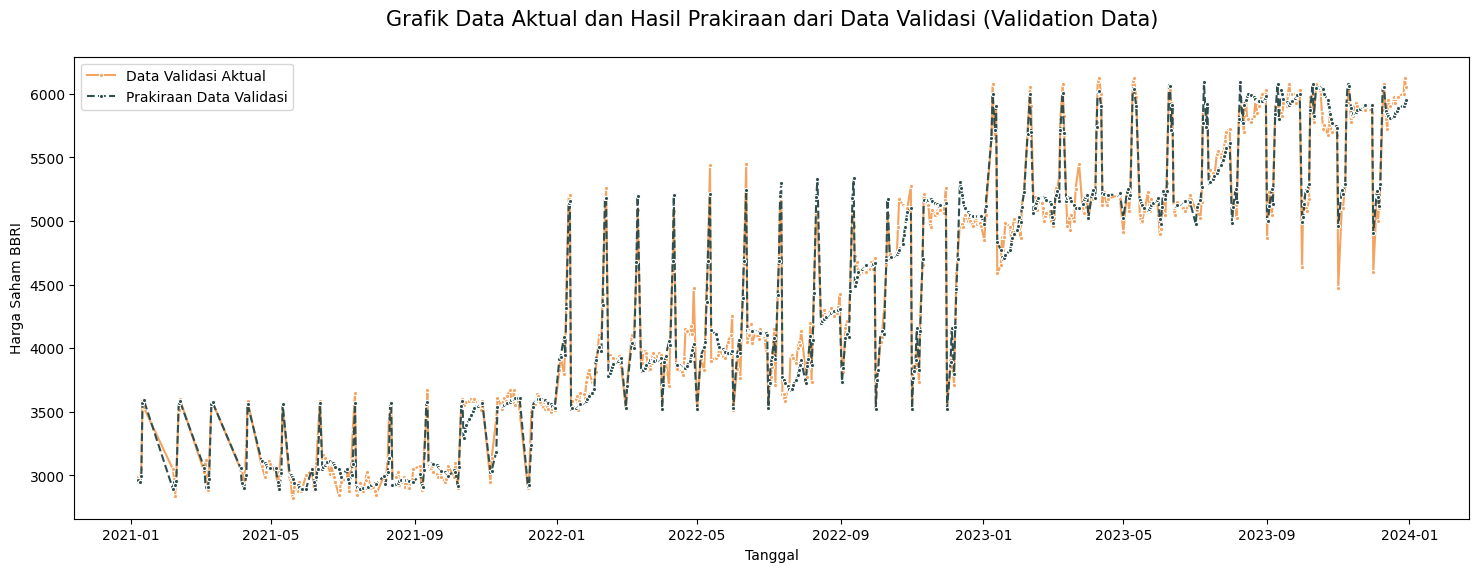

In [ ]:
plt.subplots(figsize=(18, 6))
ax = sns.lineplot(x="Date", y="Actual", data=df_val,
                    label="Data Validasi Aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val,
                    label="Prakiraan Data Validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Harga Saham BMRI')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [ ]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val Accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,6))

Forecast Val Accuracy
RMSE:  112.6005
MAE:  84.3545
MAPE:  0.019651


In [ ]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train Accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,6))

rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val Accuracy')
print('RMSE: ', round(rmse,4))
print('MAE: ', round(mae,4))
print('MAPE: ', round(mape,6))

Forecast Train Accuracy
RMSE:  105.3447
MAE:  72.9088
MAPE:  0.025778
Forecast Val Accuracy
RMSE:  112.6005
MAE:  84.3545
MAPE:  0.019651


In [ ]:
# Meramalkan Untuk 15 Periode Ke Depan
forecast_values = multi_step_forecasts(n_lookback=n_lookback, n_forecast=727, model=model, data=bmri, data_scaled=bmri_scaled)

1/1 [==============================] - 0s 31ms/step


In [ ]:
# Rentang Tanggal Yang Akan Diramal
date_forecast = [dt.strftime('%Y-%m-%d') for dt in
       datetime_range(datetime(2024, 1, 2), datetime(2025, 12, 29),
       relativedelta(days=1))]

print(np.shape(date_forecast))

(727,)


In [ ]:
# Hasil Peramalan
df_forecast = pd.DataFrame(columns=['Date', 'Forecast'])
df_forecast['Date'] = date_forecast
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
df_forecast['Forecast'] = np.squeeze(forecast_values)
df_forecast

,Date,Forecast
0,2024-01-02,4836.708911
1,2024-01-03,4812.779955
2,2024-01-04,4769.273852
3,2024-01-05,4718.462206
4,2024-01-06,4662.856127
...,...,...
722,2025-12-24,4736.885790
723,2025-12-25,4740.136035
724,2025-12-26,4743.527392
725,2025-12-27,4747.053027


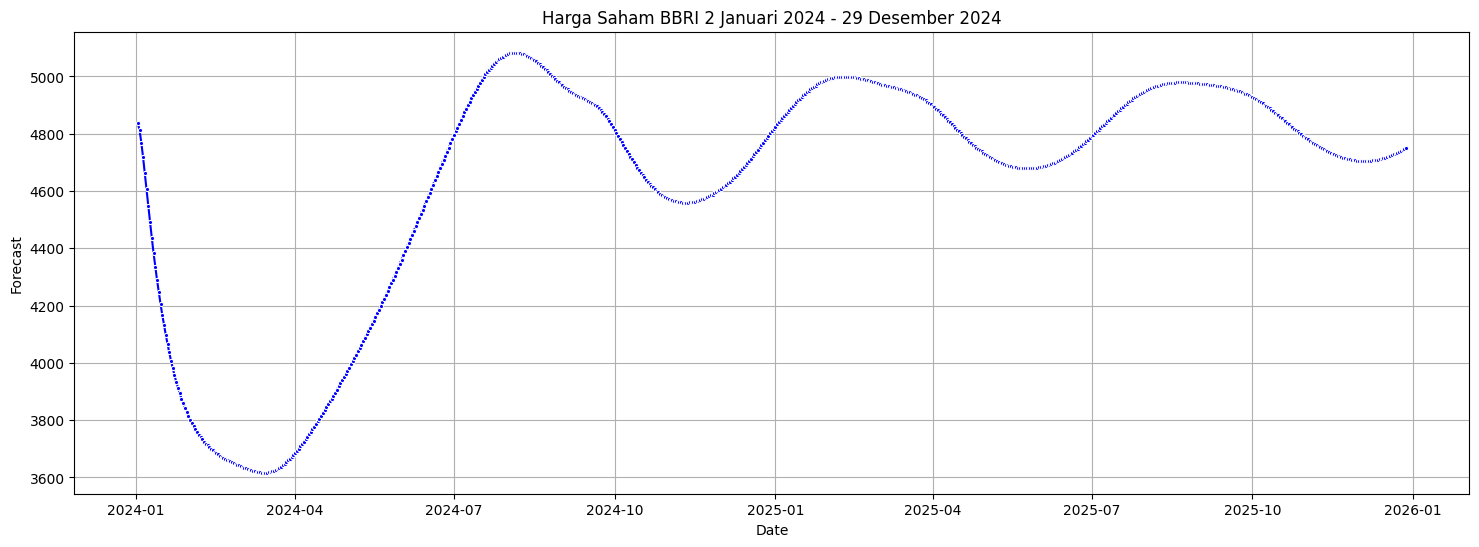

In [ ]:
# Plot Hasil Peramalan
from turtle import color

plt.subplots(figsize = (18,6))
sns.lineplot(x="Date", y="Forecast",
             data=df_forecast, marker='.', color = 'blue')
plt.title("Harga Saham BMRI 2 Januari 2024 - 29 Desember 2024")
plt.grid()

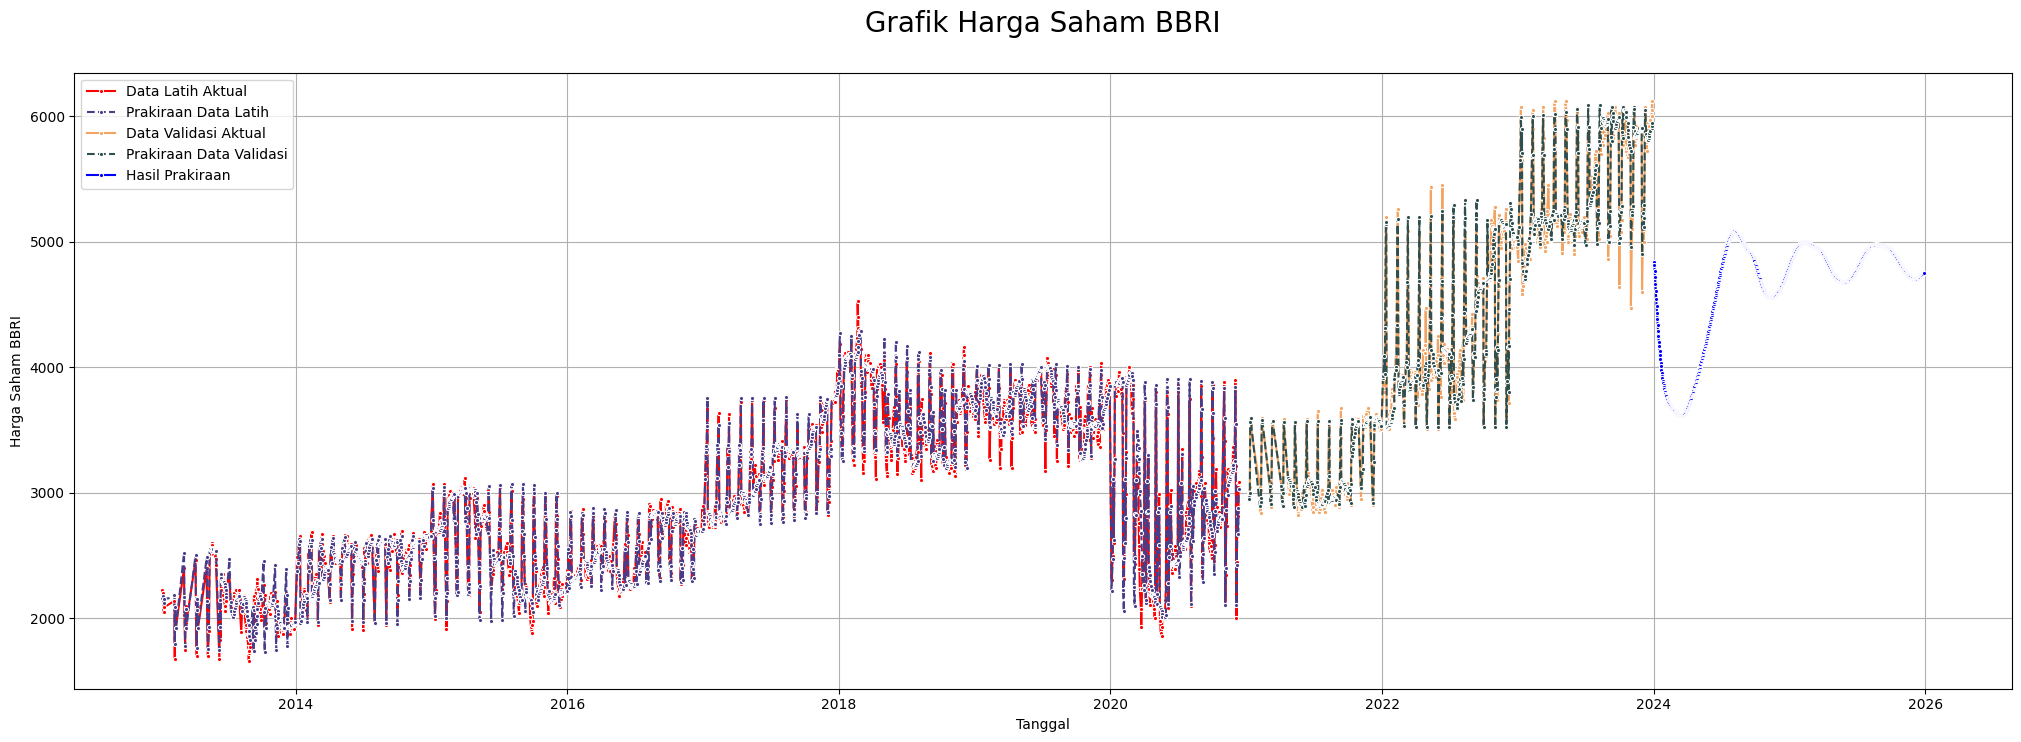

In [ ]:
# Plot Data Aktual dan Hasil Peramalan
fig, ax = plt.subplots(figsize = (25,8))
ax = sns.lineplot(x="Date", y="Actual", data=df_train,
                    label="Data Latih Aktual", marker='.', color='red')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train,
                    label="Prakiraan Data Latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val,
                    label="Data Validasi Aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val,
                    label="Prakiraan Data Validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast,
                    label="Hasil Prakiraan", marker='.', color = 'blue')
plt.grid()
plt.xlabel('Tanggal'); plt.ylabel('Harga Saham BMRI')
plt.title("Grafik Harga Saham BMRI\n", fontsize = 20)
plt.legend(loc='upper left')

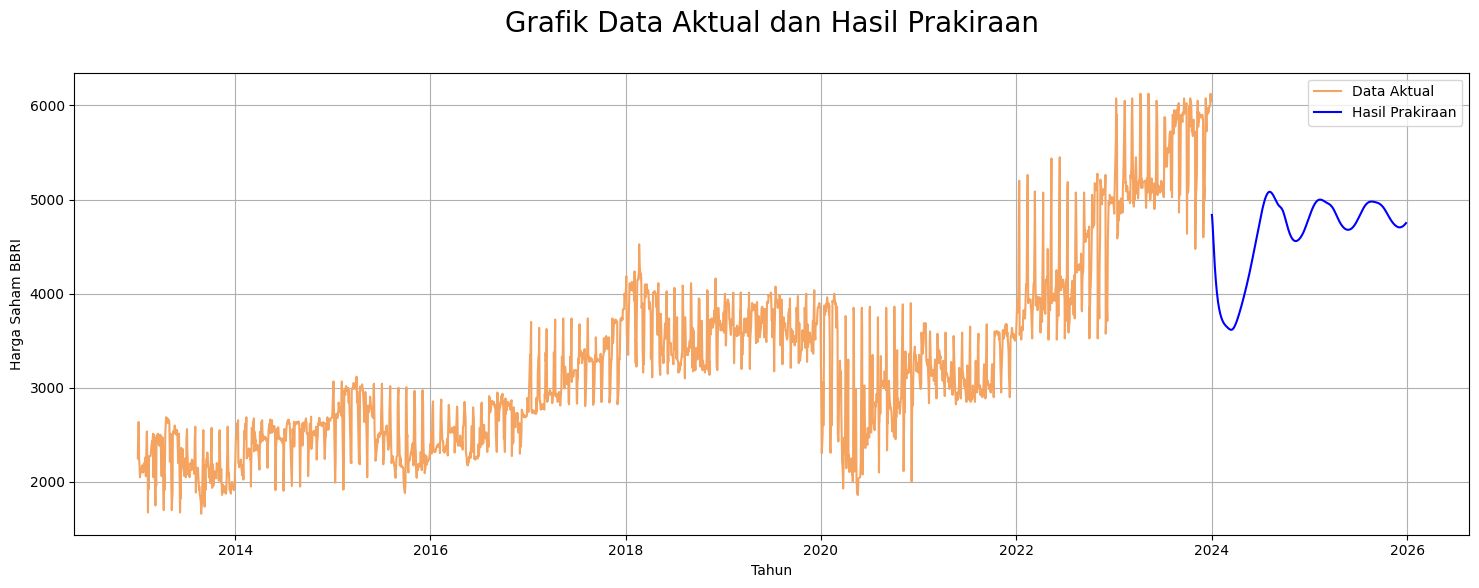

In [ ]:
fig, ax = plt.subplots(figsize = (18,6))
ax = sns.lineplot(x="Date", y="Close", data=df,
                    label="Data Aktual", color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast,
                    label="Hasil Prakiraan", color='blue')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.xlabel('Tahun'); plt.ylabel('Harga Saham BMRI')
plt.grid()